In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 66.5MB/s]


Epoch 1/100
train Loss: 0.3840 Acc: 0.8071
val Loss: 0.1894 Acc: 0.9188

Epoch 2/100
train Loss: 0.1339 Acc: 0.9571
val Loss: 0.0417 Acc: 1.0000

Epoch 3/100
train Loss: 0.0880 Acc: 0.9661
val Loss: 0.0327 Acc: 0.9875

Epoch 4/100
train Loss: 0.0408 Acc: 0.9839
val Loss: 0.0710 Acc: 0.9688

Epoch 5/100
train Loss: 0.0192 Acc: 0.9929
val Loss: 0.0494 Acc: 0.9813

Epoch 6/100
train Loss: 0.0199 Acc: 0.9946
val Loss: 0.0777 Acc: 0.9688

Epoch 7/100
train Loss: 0.0136 Acc: 0.9982
val Loss: 0.0538 Acc: 0.9813

Epoch 8/100
train Loss: 0.0147 Acc: 0.9964
val Loss: 0.0499 Acc: 0.9750

Epoch 9/100
train Loss: 0.0233 Acc: 0.9929
val Loss: 0.0410 Acc: 0.9875

Epoch 10/100
train Loss: 0.0145 Acc: 0.9929
val Loss: 0.0476 Acc: 0.9813

Epoch 11/100
train Loss: 0.0351 Acc: 0.9946
val Loss: 0.0264 Acc: 0.9938

Epoch 12/100
train Loss: 0.0407 Acc: 0.9839
val Loss: 0.0215 Acc: 0.9938

Epoch 13/100
train Loss: 0.0366 Acc: 0.9893
val Loss: 0.2491 Acc: 0.8813

Epoch 14/100
train Loss: 0.0447 Acc: 0.9875
val

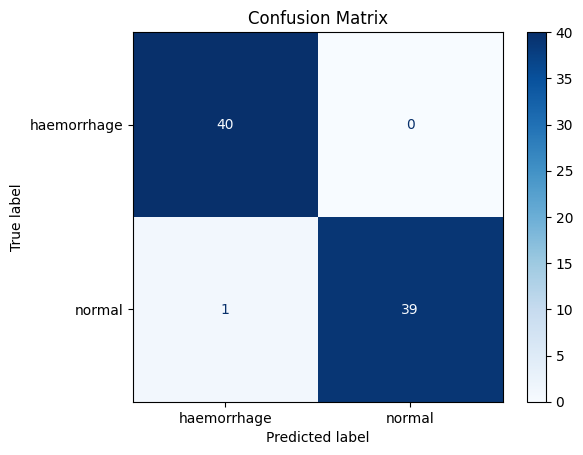

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
from collections import Counter
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === CONFIGURATION ===
data_dir = '/content/drive/MyDrive/FYP/data'  # Make sure path uses double backslashes or raw string
batch_size = 32
num_epochs = 100
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === TRANSFORMS ===
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

# === DATASETS ===
image_datasets = {
    x: datasets.ImageFolder(root=f'{data_dir}/{x}', transform=transform[x])
    for x in ['train', 'val', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

# === SAMPLER FOR BALANCED TRAINING ===
train_labels = [label for _, label in image_datasets['train'].imgs]
class_counts = Counter(train_labels)
weights = [1.0 / class_counts[label] for label in train_labels]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# === DATALOADERS ===
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, sampler=sampler),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)
}

# === CLASS WEIGHTS FOR LOSS FUNCTION ===
total_samples = sum(class_counts.values())
class_weights = [total_samples / (num_classes * class_counts[i]) for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# === MODEL ===
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# === OPTIMIZER ===
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# === TRAINING FUNCTION ===
def train_model(model, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# === TRAIN THE MODEL ===
model = train_model(model, criterion, optimizer, num_epochs=num_epochs)

# === TEST FUNCTION WITH CONFUSION MATRIX ===
def test_model(model):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f'\nTest Accuracy: {100 * correct / total:.2f}%')

    # Per-class accuracy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    for i, class_name in enumerate(class_names):
        class_total = (all_labels == i).sum()
        class_correct = ((all_preds == i) & (all_labels == i)).sum()
        acc = 100 * class_correct / class_total if class_total > 0 else 0
        print(f'Class [{class_name}] Accuracy: {acc:.2f}%')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# === TEST THE MODEL ===
test_model(model)
